In [1]:
import matplotlib.pyplot as plt
import numpy as np
from model_based.train import make_train, HyperParams,  SARSDTuple, make_catch_bce_loss_fn, make_catch_accuracy_loss_fn
from model_based.transition_models import CatchModel, CatchEquiModel
from model_based.sample_env import make_experience_fn, make_expert_experience_fn
import pickle
import jax
import jax.numpy as jnp
import base_rl.higher_order as ho
from base_rl.models import ActorCritic
import matplotlib
from gymnax.environments.bsuite import Catch

In [2]:
cfg = ho.CONFIG
cfg["ENV"] = Catch()
cfg["ENV_PARAMS"] = Catch().default_params
train_fn = jax.jit(ho.make_train(cfg, ActorCritic))
result = train_fn(jax.random.PRNGKey(42))

In [3]:
runner_state= result["runner_state"]
expert_params = runner_state[0].params

In [4]:
num = 2000
keys = jax.random.split(jax.random.PRNGKey(42), num)
random_data = jax.jit(jax.vmap(make_experience_fn("Catch-bsuite", 500)))(keys)
random_data_len = np.prod(random_data.reward.shape)
random_data = jax.tree_map(lambda x: x.reshape((random_data_len, -1)), random_data)

expert_data = jax.jit(jax.vmap(make_expert_experience_fn("Catch-bsuite", 500, expert_params)))(keys)
expert_data_len= np.prod(expert_data.reward.shape)
expert_data= jax.tree_map(lambda x: x.reshape((expert_data_len, -1)), expert_data)

/home/sean/ms_mono/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [5]:
hyp = HyperParams(model=CatchModel, train_frac=0.8)
data = random_data.join(expert_data)
data_len = np.prod(data.reward.shape)
data = jax.tree_map(lambda x: x.reshape(data_len, -1), data)
perm = np.random.permutation(data_len)
data = jax.tree_map(lambda x: x.at[perm, ...].get(), data)

# non_zero = (data.done ==0).reshape(-1)
# data = jax.tree_map(lambda x: x.at[non_zero, ...].get(), data)



train_data, val_data = data.partition(hyp.get_train_size(data))
filtered_data = train_data.filter_by_action(0)

# jax.tree_map(lambda x: print(x.shape), train_data)
# jax.tree_map(lambda x: print(x.shape), val_data)

In [6]:
def train_model(hyp, train_data, val_data):
    train = make_train(hyp, train_data, val_data, loss_function_ho=make_catch_bce_loss_fn, val_loss_function_ho=make_catch_accuracy_loss_fn)
    result = train(jax.random.PRNGKey(42))
    losses = result[1][0]
    return losses.train_loss.reshape(-1), losses.val_loss.reshape(-1), result[0] 
def get_x(loss, epoch):
    return np.linspace(0, epoch, len(loss))

In [7]:
EPCH=100
hyp = HyperParams(model=CatchModel, train_frac=1, epochs=EPCH, learning_rate=1e-5)
hyp_equi = HyperParams(model=CatchEquiModel, train_frac=1, epochs=EPCH, learning_rate=1e-5)
hyps = [ hyp, hyp_equi]
datas = [train_data, filtered_data, random_data]


In [8]:
moving_average = lambda x, w: np.convolve(x, np.ones(w), 'valid') / w
cs = ["blue", "indigo"]
sol =[]
models = {}
for hyp, c in zip(hyps, cs):
    sub_sol = []
    for i, data in enumerate(datas):
        train_loss, val_loss, runner_state= train_model(hyp, data, val_data)
        sub_sol.append((train_loss, val_loss))
        models[(hyp.model.__name__, i)] =runner_state 
        
    sol.append(sub_sol)

2023-08-10 13:49:22.746508: W external/xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:523] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  /usr/local/cuda-12.0
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


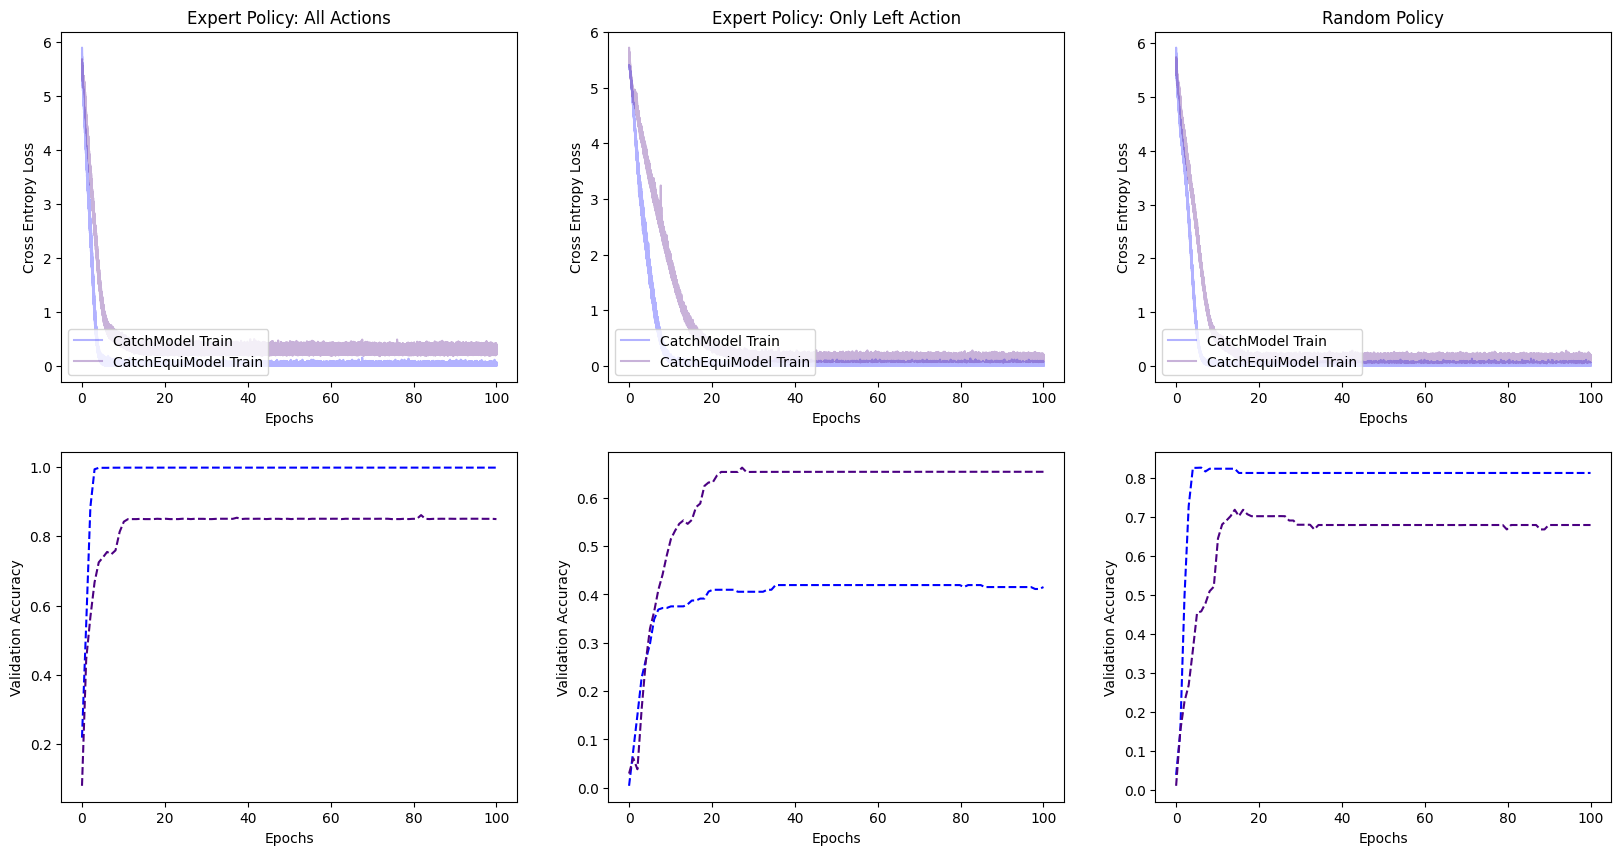

In [9]:
titles = ["Expert Policy: All Actions", "Expert Policy: Only Left Action", "Random Policy"]
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
assert len(sol) == len(hyps) == len(cs)
for sub_sol, hyp, c in zip(sol, hyps, cs):

    for i, ((train_loss, val_loss), tit) in enumerate(zip(sub_sol, titles)):
        # train_loss= moving_average(train_loss, 10)
        ax[0, i].plot(get_x(train_loss, hyp.epochs),train_loss, label=f"{hyp.model.__name__} Train", color=c, alpha = 0.3)
        if tit == "Random Policy":
            ax[1, i].plot(get_x(val_loss, hyp.epochs), val_loss, label=f"{hyp.model.__name__} Expert Policy Validation", color=c, linestyle="--")
        else: 
            ax[1, i].plot(get_x(val_loss, hyp.epochs), val_loss, label=f"{hyp.model.__name__} Val", color=c, linestyle="--")
        ax[0, i].legend(loc="lower left")
        ax[0, i].set_xlabel("Epochs")
        ax[1, i].set_xlabel("Epochs")
        ax[0, i].set_ylabel("Cross Entropy Loss")
        ax[1, i].set_ylabel("Validation Accuracy")
        ax[0, i].set_title(tit)
        # ax[0, i].set_xlim(0, EPCH)
        # ax[1, i].set_ylim(0, 1)

In [10]:
rng = jax.random.PRNGKey(42)
key = jax.random.split(rng, 500)
train = jax.jit(ho.make_train(ho.CONFIG, ActorCritic))

result = train(rng)
runner_state= result["runner_state"]


# Catch Playground

In [11]:
from base_rl.wrappers import FlattenObservationWrapper
env = FlattenObservationWrapper(Catch())
env_params = env.default_params
ts = models[("CatchModel", 2)][1]

In [12]:
def _accuracy(ball_dist, paddle_dist, next_state):
    ball_pred = jnp.zeros_like(ball_dist.probs).at[ball_dist.mode()].set(1.0)
    paddle_pred = (
        jnp.zeros_like(paddle_dist.probs).at[paddle_dist.mode()].set(1.0)
    )
    pred = jnp.concatenate(
        [
            ball_pred.reshape(45),
            paddle_pred.reshape(5),
        ],
        axis=0,
    )
    accuracy = pred == next_state
    return accuracy.all()
# def sample_action(key):
#     action = env.sample_action(key)
#     return action
    

accs = []
num_envs = 100
single_key = jax.random.PRNGKey(0)
key = jax.random.split(single_key, num_envs)
obs, env_state = jax.vmap(env.reset, in_axes=(0, None))(key, env_params)
aply = ts.apply_fn
other_acc = []
policy_aply = jax.vmap(ActorCritic(3).apply, in_axes =(None, 0))

for i in range(100):
    _, single_key = jax.random.split(single_key)
    # action = jax.random.randint(single_key, minval=0, maxval=3, shape=(num_envs,))
    action = policy_aply(expert_params, obs)[0].sample(seed=single_key)
    ball_dist, pad_dist = aply(ts.params, obs, action)
    next_obs, env_state, rew, done, info = jax.vmap(env.step)(key, env_state, action)

    prediction = jax.vmap(_accuracy)(ball_dist, pad_dist, next_obs)
    obs = next_obs
    accs.append(prediction.mean())

print(jnp.stack(accs).mean())



0.61859995
